In [45]:
import math
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, norm
from scipy.optimize import minimize
import scipy.interpolate as scinterp
import torch
import matplotlib.pyplot as plt
import nn_utils as nn_ut

In [46]:
def gaussian_kernel(x, y, x0, y0, radius, level):
    distance_2 = torch.pow(x - x0, 2) + torch.pow(y - y0, 2)
    cost = torch.zeros(x.size())
    mask = distance_2 < torch.pow(radius, 2)
    cost[mask] = level * torch.exp(1. + torch.pow(radius, 2) / (torch.masked_select(distance_2, mask) - torch.pow(radius, 2)))
    return cost

In [47]:
# setting latex style for plots
plt.rcParams['text.usetex'] = True

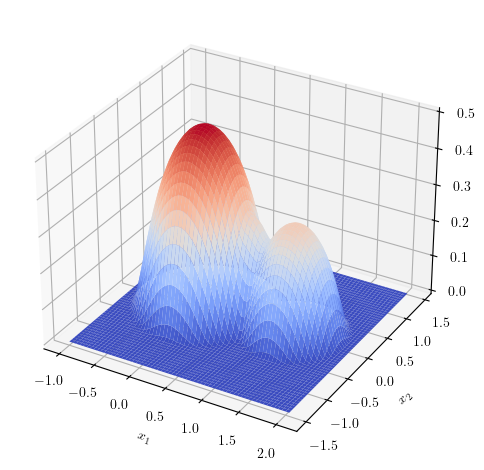

In [48]:
# defining the cost functional as a double dome function
x01 = 0.
y01 = 0.
radius1 = 1.
level1 = 0.5
x02 = 1.25
y02 = 0.
radius2 = 0.75
level2 = 0.3

def f(x, y):
    return gaussian_kernel(x, y, x01, y01, torch.tensor(radius1), torch.tensor(level1)) + gaussian_kernel(x, y, x02, y02, torch.tensor(radius2), torch.tensor(level2))

x_1 = torch.arange(-1., 2.1, 0.05)
x_2 = torch.arange(-1.5, 1.5, 0.05)
xv, yv = torch.meshgrid(x_1, x_2, indexing='ij')
zg = f(xv, yv)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xv, yv, zg, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.tight_layout()
plt.show()

In [49]:
# reference measure
mean = torch.tensor([0.75, 0.25])
covmat = torch.eye(2)

mu = torch.distributions.MultivariateNormal(loc = mean, covariance_matrix=covmat)

In [50]:
# cost functional
p = 2
def euclid_norm(u):
    return torch.pow(u, 2).sum(dim=1).sqrt()
def cost(u):
    return torch.pow(euclid_norm(u), p) / p

In [51]:
### risk measure by neural network approximation
width = 20
depth = 4
sample_size = 100
risk_measure = nn_ut.RiskMeasure2d(f, cost, mu, torch.nn.ReLU, width, depth)

# otpimizer
optim = torch.optim.Adam(risk_measure.parameters(), lr=0.001)

# fixing the seed
torch.manual_seed(29)

# traning cycle
train_hist = []
epochs = 10000
for i in range(epochs):
    optim.zero_grad()
    y = mu.sample([sample_size])
    risk = risk_measure(y)
    risk.backward()
    optim.step()
    train_hist.append(- float(risk.detach()))

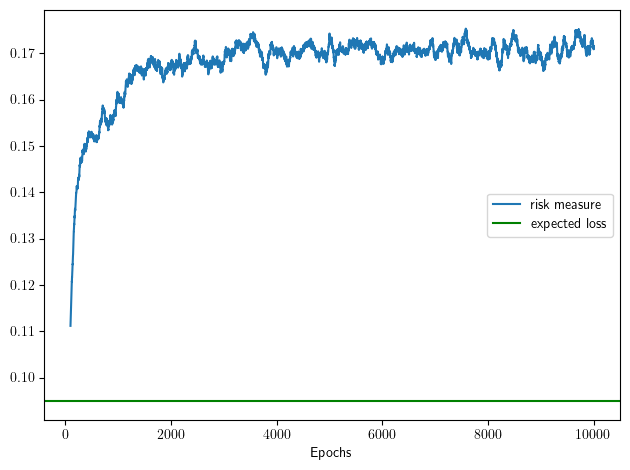

In [52]:
# training epochs

roll_window = 100
train_roll = pd.Series(train_hist).rolling(roll_window).mean().dropna()

final_samples = mu.sample([100000])
expected_loss = torch.mean(f(final_samples[:, 0], final_samples[:, 1]))
plt.plot(1 + np.arange(roll_window, epochs + 1), train_roll, label=f'risk measure')
plt.axhline(float(expected_loss), color='green', label='expected loss')
plt.xlabel("Epochs")
plt.legend()
plt.tight_layout()
plt.show()


In [53]:
# results

risk_measure.eval()
risk_meas = risk_measure(final_samples)
mc_err = 2.57 * risk_measure.mc_err
print(f"risk measure value: {risk_meas:.3e}, mc error: {mc_err:.3e}")
print(f"confindence interval: {risk_meas - mc_err:.3e}, {risk_meas + mc_err:.3e}")
print(f"expected loss: {expected_loss:.3e}")

risk measure value: 1.703e-01, mc error: 1.362e-03
confindence interval: 1.689e-01, 1.716e-01
expected loss: 9.482e-02


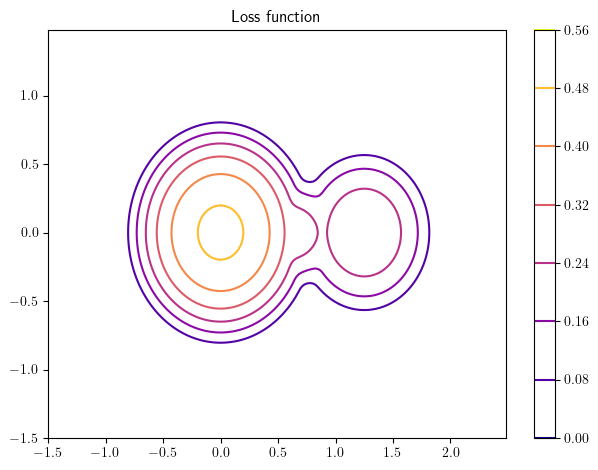

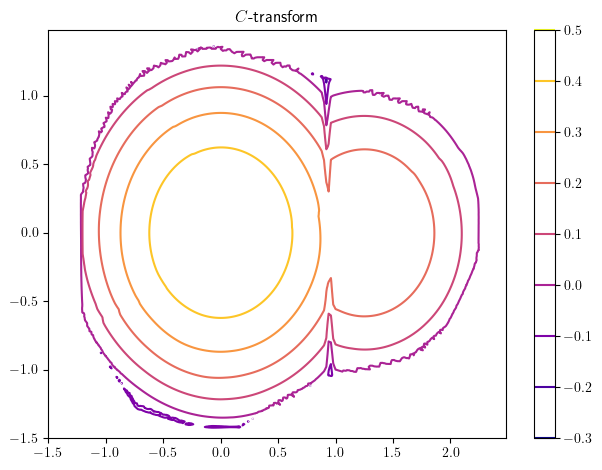

In [54]:
# contour plots of the loss function and its C-transform

x_cont = torch.arange(-1.5, 2.5, 0.02)
y_cont = torch.arange(-1.5, 1.5, 0.02)
xv, yv = torch.meshgrid(x_cont, y_cont, indexing='ij')
cont_points = torch.stack((xv.flatten(),yv.flatten()), dim=1)

ccong = risk_measure.ccong(cont_points)
orig_func = f(cont_points[:, 0], cont_points[:, 1])


# First contour plot
plt.tricontour(cont_points.detach()[:, 0], cont_points.detach()[:, 1], orig_func.detach(), cmap='plasma')
plt.title('Loss function')
plt.colorbar()
plt.tight_layout()
plt.show()

# Second contour plot
plt.tricontour(cont_points.detach()[:, 0], cont_points.detach()[:, 1], ccong.detach(), cmap='plasma')
plt.title(r'$C$-transform')
plt.colorbar()
plt.tight_layout()
plt.show()


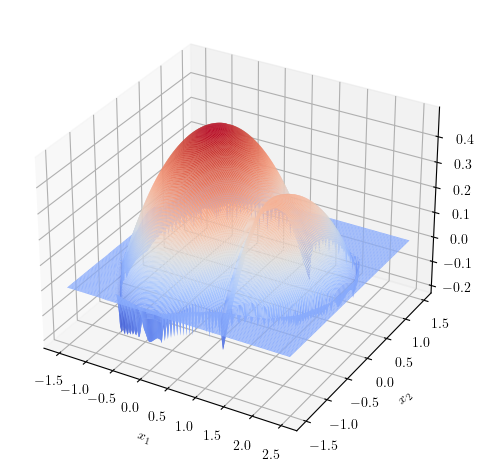

In [55]:
## Plot of the C-transform of the loss function

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xv.detach(), yv.detach(), torch.reshape(ccong, (x_cont.shape[0], y_cont.shape[0])).detach(), rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.tight_layout()
plt.show()